# EMD: Emotional tweets

## Installing packages

In [1]:
!pip install unidecode
!pip install contractions
!pip install wordsegment
!pip install emoji --upgrade

Requirement already up-to-date: symspellpy in /usr/local/lib/python3.6/dist-packages (6.5.2)
Requirement already up-to-date: emoji in /usr/local/lib/python3.6/dist-packages (0.5.4)
Requirement already up-to-date: imbalanced-learn in /usr/local/lib/python3.6/dist-packages (0.6.1)


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from bs4 import BeautifulSoup
import unidecode
import contractions
import gensim.downloader as api
import re
import wordsegment
import pkg_resources
import emoji

Using TensorFlow backend.


True

### Mounting drive

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
PATH_TO_DIR = '/content/drive/My Drive/STUDIA/SEM 9/emd/'

Mounted at /content/drive


## Loading data

In [99]:
training_examples_url = PATH_TO_DIR + 'train.csv'
training_dataset = pd.read_csv(training_examples_url, delimiter=',')
training_dataset.head()

,Id,Category,Tweet
0,635769805279248384,negative,Not Available
1,635930169241374720,neutral,IOS 9 App Transport Security. Mm need to check...
2,635950258682523648,neutral,"Mar if you have an iOS device, you should down..."
3,636030803433009153,negative,@jimmie_vanagon my phone does not run on lates...
4,636100906224848896,positive,Not sure how to start your publication on iOS?...


In [79]:
len(training_dataset)

(5969, 9968)

In [80]:
len(training_dataset[training_dataset.Tweet =='Not Available'])

(548, 360)

In [81]:
len(training_dataset[training_dataset.Category =='Not Available'])

0

In [82]:
X_train = list(training_dataset[training_dataset.Tweet != 'Not Available'].Tweet)
len(X_train)

5421

In [83]:
X_train[:10]

['IOS 9 App Transport Security. Mm need to check if my 3rd party network pod supports it http://t.co/fmtcfUAdgj',
 'Mar if you have an iOS device, you should download our app too: http://t.co/gl3tn2uDnD',
 '@jimmie_vanagon my phone does not run on latest IOS which may account for problem the other day .. time it was replaced',
 "Not sure how to start your publication on iOS? We'll be live helping with ask me anything sessions today and Friday http://t.co/KPqqGjjh3x",
 'Two Dollar Tuesday is here with Forklift 2, QuickKey for iOS and Suite for Pages for just $1.99 today:   http://t.co/BNMFOEACw5',
 "If you're not already signed up to test my iOS game, nows your chance! https://t.co/eZhIU6EDpQ",
 'YouTube Gaming Officially Launches On Web, Android, iOS On August 26: YouTube is finally going to r... http://t.co/qbhyA3kaWP #webseries',
 'YouTube Gaming Launches Tomorrow with iOS and Android Apps to Go Head-to-Head with Twitch http://t.co/yZOATToeJC #ios #game',
 "@astrill Yashan from BBC @

In [84]:
mapping = {'positive': 0, 'neutral': 1, 'negative': 2}
Y_train = list(training_dataset[training_dataset.Tweet != 'Not Available'].Category.replace(mapping))
Y_train[:10]

[1, 1, 2, 0, 1, 1, 1, 1, 1, 0]

### Class imbalance

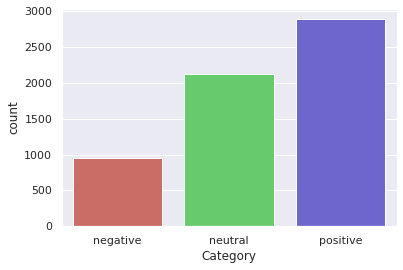

Category
negative     956
neutral     2125
positive    2888
Name: Id, dtype: int64


In [58]:
sns.set(font_scale=1.0)
countplt=sns.countplot(x='Category', data=training_dataset, palette ='hls')
plt.show()

print(training_dataset.groupby('Category').count().Id)

In [85]:
training_examples_url = 'https://raw.githubusercontent.com/piotrjaniszewski1/SemEval-2020-Task12/master/data2019/olid-training-v1.0.tsv'
training_dataset_semeval = pd.read_csv(training_examples_url, delimiter='\t')
training_dataset_semeval.head()

,id,tweet,subtask_a,subtask_b,subtask_c
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN


In [0]:
X_train_semeval = training_dataset_semeval['tweet'][training_dataset_semeval['subtask_a'].notnull()]
Y_train_semeval = (training_dataset_semeval['subtask_a'][training_dataset_semeval['subtask_a'].notnull()] == 'OFF').astype(int) * 2

X_train_semeval = list(X_train_semeval)
Y_train_semeval = list(Y_train_semeval)

In [87]:
X_train_semeval[:10]

['@USER She should ask a few native Americans what their take on this is.',
 '@USER @USER Go home you’re drunk!!! @USER #MAGA #Trump2020 👊🇺🇸👊 URL',
 'Amazon is investigating Chinese employees who are selling internal data to third-party sellers looking for an edge in the competitive marketplace. URL #Amazon #MAGA #KAG #CHINA #TCOT',
 '@USER Someone should\'veTaken" this piece of shit to a volcano. 😂"',
 '@USER @USER Obama wanted liberals &amp; illegals to move into red states',
 '@USER Liberals are all Kookoo !!!',
 '@USER @USER Oh noes! Tough shit.',
 '@USER was literally just talking about this lol all mass shootings like that have been set ups. it’s propaganda used to divide us on major issues like gun control and terrorism',
 '@USER Buy more icecream!!!',
 '@USER Canada doesn’t need another CUCK! We already have enough #LooneyLeft #Liberals f**king up our great country! #Qproofs #TrudeauMustGo']

In [88]:
Y_train_semeval[:10]

[2, 2, 0, 2, 0, 2, 2, 2, 0, 2]

In [89]:
sum(np.array(Y_train_semeval) > 0)

4400

In [0]:
X_train = X_train + X_train_semeval[:1169]
Y_train = Y_train + Y_train_semeval[:1169]

## Preprocessing

In [0]:
# remove html tags if exist
def strip_html_tags(text):
    soup = BeautifulSoup(text, 'html.parser')
    stripped_text = soup.get_text(separator=' ')
    return stripped_text


# remove unnecessary whitespaces
def remove_whitespace(text):
    text = text.strip()
    return ' '.join(text.split())


# remove accented chars (e.g. caffè -> caffe)
def remove_accented_chars(text):
    text = unidecode.unidecode(text)
    return text


# remove hashes and split words (e.g. '#fortTrump' -> 'fort trump')
def split_hashtags(text):
    splitted = text.split()
    new_word_sequence = []

    for chunk in splitted:
        if chunk[0] == '#':
            chunk = chunk[1:]
            new_word_sequence.extend(wordsegment.segment(chunk))
        else:
            new_word_sequence.append(chunk)
        
    return ' '.join(tuple(new_word_sequence))


def substitute_emojis(text):
    demojized_text = emoji.demojize(text)
    return re.compile('[_:]+').sub(' ', demojized_text)


def preprocess_common(text):
    text = strip_html_tags(text)
    text = contractions.fix(text)
    text = split_hashtags(text)
    text = substitute_emojis(text)
    text = remove_whitespace(text)
    text = remove_accented_chars(text)
    return text.lower()

In [27]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                            np.unique(Y_train),
                                            Y_train)
class_weights /= max(class_weights)
class_weights

array([0.33433554, 0.44515612, 1.        ])

In [0]:
X_train = [preprocess_common(example) for example in X_train]

In [0]:
seed = 13

X_train, X_test, Y_train, Y_test = train_test_split(
    X_train, Y_train, test_size=0.2, stratify=Y_train, random_state=seed)
# X_train, X_valid, Y_train, Y_valid = train_test_split(
#     X_train, Y_train, test_size=0.2, stratify=Y_train, random_state=seed)

## Albert

In [16]:
! pip install simpletransformers

     |████████████████████████████████| 102kB 2.9MB/s 
     |████████████████████████████████| 204kB 10.8MB/s 
     |████████████████████████████████| 1.4MB 78.3MB/s 
     |████████████████████████████████| 450kB 64.9MB/s 
     |████████████████████████████████| 102kB 16.0MB/s 
     |████████████████████████████████| 92kB 15.0MB/s 
     |████████████████████████████████| 102kB 14.9MB/s 
     |████████████████████████████████| 460kB 62.4MB/s 
     |████████████████████████████████| 1.0MB 46.3MB/s 
     |████████████████████████████████| 870kB 42.1MB/s 
     |████████████████████████████████| 71kB 12.0MB/s 
     |████████████████████████████████| 71kB 13.6MB/s 
  Created wheel for seqeval: filename=seqeval-0.0.12-cp36-none-any.whl size=7424 sha256=7239ccb17ff28ddefec241e8cb351c578fee32e06d17cd45d10743cbcc65ffe9
  Stored in directory: /root/.cache/pip/wheels/4f/32/0a/df3b340a82583566975377d65e724895b3fad101a3fb729f68
  Created wheel for shortuuid: filename=shortuuid-0.5.0-cp36-none-any.wh

In [17]:
! git clone https://github.com/NVIDIA/apex
! pip install -v --no-cache-dir ./apex

Cloning into 'apex'...
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 5632 (delta 20), reused 23 (delta 10), pack-reused 5585
Receiving objects: 100% (5632/5632), 13.37 MiB | 26.85 MiB/s, done.
Resolving deltas: 100% (3641/3641), done.
Created temporary directory: /tmp/pip-ephem-wheel-cache-6mg3b2nc
Created temporary directory: /tmp/pip-req-tracker-itiguyqz
Created requirements tracker '/tmp/pip-req-tracker-itiguyqz'
Created temporary directory: /tmp/pip-install-f_0y5q75
Processing ./apex
  Created temporary directory: /tmp/pip-req-build-a7vybwcj
  Added file:///content/apex to build tracker '/tmp/pip-req-tracker-itiguyqz'
    Running setup.py (path:/tmp/pip-req-build-a7vybwcj/setup.py) egg_info for package from file:///content/apex
    Running command python setup.py egg_info
    torch.__version__  =  1.3.1
    running egg_info
    creating /tmp/pip-req-build-a7vybwcj/pip-egg-info/apex

In [0]:
def create_data_frame(X, Y):
    df = pd.DataFrame([])

    for x, y in zip(X, Y):
        row_df = pd.DataFrame([[x, y]])
        df = train_df.append(row_df)

    return df

In [94]:
train_df = create_data_frame(X_train, Y_train)
train_df.head()

,0,1
0,science behind the movie dinosaur dna extracti...,1
0,"biden on 2016 run ""i just do not know"" vice pr...",1
0,"there is a simple solution, just deport all th...",2
0,go follow this guys @sykeonair he is going to ...,0
0,biden gauging his 'emotional fuel' vice presid...,1


In [95]:
eval_df = create_data_frame(X_test, Y_test)
eval_df.head()

,0,1
0,someone go see jurassic world with me tomorrow...,0
0,@user sam was singing and they did not tell he...,2
0,@user @user mxm nigger thinks we give a fuck url,2
0,manitoba - ndp leader wab kinew on the carbon ...,2
0,"win10 build 10525 brings more color, better me...",0


In [42]:
from simpletransformers.classification import ClassificationModel

model = ClassificationModel('albert', 'albert-base-v1', num_labels=3, weight=list(class_weights), args={'overwrite_output_dir': True})
model.train_model(train_df, args={'num_train_epochs': 3})

Features loaded from cache at cache_dir/cached_train_albert_128_3_4336
Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:183: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn("Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.")


Running loss: 1.228082Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
Running loss: 1.298195

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:91: UserWarning: Seems like `optimizer.step()` has been overridden after learning rate scheduler initialization. Please, make sure to call `optimizer.step()` before `lr_scheduler.step()`. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Running loss: 1.161019Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
Running loss: 1.672190Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
Running loss: 1.576800

Running loss: 0.995600Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0
Running loss: 0.668466

Running loss: 0.334625
Training of albert model complete. Saved to outputs/.


In [43]:
# Evaluate the model (without additional data)
from sklearn.metrics import accuracy_score
result, model_outputs, wrong_predictions = model.eval_model(eval_df, acc=accuracy_score)
result

Features loaded from cache at cache_dir/cached_dev_albert_128_3_1085


/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:458: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn("Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.")


{'acc': 0.6073732718894009,
 'eval_loss': 0.9238702238482588,
 'mcc': 0.370194043881845}

In [96]:
from simpletransformers.classification import ClassificationModel

model = ClassificationModel('albert', 'albert-base-v1', num_labels=3, args={'output_dir': 'add_data_outputs/'})
model.train_model(train_df, args={'num_train_epochs': 5})

Converting to features started. Cache is not used.


/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:183: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn("Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.")



Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


Running loss: 1.178419

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:91: UserWarning: Seems like `optimizer.step()` has been overridden after learning rate scheduler initialization. Please, make sure to call `optimizer.step()` before `lr_scheduler.step()`. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
Running loss: 1.058153Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
Running loss: 0.798899

Running loss: 0.977875Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
Running loss: 0.480340

Running loss: 0.262777

Running loss: 0.384414

Running loss: 0.408147Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
Running loss: 0.051183
Training of albert model complete. Saved to add_data_outputs/.


In [97]:
# Evaluate the model (without additional data)
from sklearn.metrics import accuracy_score
result, model_outputs, wrong_predictions = model.eval_model(eval_df, acc=accuracy_score)
result

Converting to features started. Cache is not used.


/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:458: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn("Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.")


{'acc': 0.6426403641881638,
 'eval_loss': 1.2181258117610758,
 'mcc': 0.41718259260219837}

In [98]:
! zip -r save_add_data.zip add_data_outputs

  adding: add_data_outputs/ (stored 0%)
  adding: add_data_outputs/added_tokens.json (stored 0%)
  adding: add_data_outputs/config.json (deflated 55%)
  adding: add_data_outputs/checkpoint-2636-epoch-4/ (stored 0%)
  adding: add_data_outputs/checkpoint-2636-epoch-4/added_tokens.json (stored 0%)
  adding: add_data_outputs/checkpoint-2636-epoch-4/config.json (deflated 55%)
  adding: add_data_outputs/checkpoint-2636-epoch-4/pytorch_model.bin (deflated 7%)
  adding: add_data_outputs/checkpoint-2636-epoch-4/tokenizer_config.json (deflated 3%)
  adding: add_data_outputs/checkpoint-2636-epoch-4/special_tokens_map.json (deflated 51%)
  adding: add_data_outputs/checkpoint-2636-epoch-4/spiece.model (deflated 49%)
  adding: add_data_outputs/checkpoint-1318-epoch-2/ (stored 0%)
  adding: add_data_outputs/checkpoint-1318-epoch-2/added_tokens.json (stored 0%)
  adding: add_data_outputs/checkpoint-1318-epoch-2/config.json (deflated 55%)
  adding: add_data_outputs/checkpoint-1318-epoch-2/pytorch_model

### Creating submission file

In [123]:
test_examples_url = PATH_TO_DIR + 'test.csv'
test_dataset = pd.read_csv(test_examples_url, delimiter=',')
test_dataset.head()

,Id,Tweet
0,628949369883000832,dear @Microsoft the newOoffice for Mac is grea...
1,628976607420645377,@Microsoft how about you make a system that do...
2,629023169169518592,Not Available
3,629179223232479232,Not Available
4,629186282179153920,If I make a game as a #windows10 Universal App...


In [124]:
len(test_dataset)

4000

In [125]:
len(test_dataset[test_dataset.Tweet =='Not Available'])

360

In [104]:
predictions, raw_outputs = model.predict(list(test_dataset.Tweet))

Converting to features started. Cache is not used.


In [126]:
test_dataset.head()

,Id,Tweet
0,628949369883000832,dear @Microsoft the newOoffice for Mac is grea...
1,628976607420645377,@Microsoft how about you make a system that do...
2,629023169169518592,Not Available
3,629179223232479232,Not Available
4,629186282179153920,If I make a game as a #windows10 Universal App...


In [127]:
predictions[:10]

array([0, 2, 1, 1, 1, 1, 1, 1, 0, 1])

In [0]:
preds_df = test_dataset.drop(columns=['Tweet'])

In [134]:
preds_df['Category'] = predictions
preds_df.head()

,Id,Category
0,628949369883000832,0
1,628976607420645377,2
2,629023169169518592,1
3,629179223232479232,1
4,629186282179153920,1


In [130]:
training_dataset[training_dataset.Tweet == 'Not Available'].groupby('Category').count().Id

Category
negative     87
neutral     172
positive    289
Name: Id, dtype: int64

In [135]:
preds_df.loc[test_dataset.Tweet == 'Not Available', "Category"] = 0
preds_df.head()

,Id,Category
0,628949369883000832,0
1,628976607420645377,2
2,629023169169518592,0
3,629179223232479232,0
4,629186282179153920,1


In [137]:
mapping = {0: 'positive', 1: 'neutral', 2: 'negative'}
preds_df.Category = preds_df.Category.replace(mapping)
preds_df.head()

,Id,Category
0,628949369883000832,positive
1,628976607420645377,negative
2,629023169169518592,positive
3,629179223232479232,positive
4,629186282179153920,neutral


In [0]:
preds_df.to_csv(PATH_TO_DIR + 'submission.csv', index=False)

## Roberta

In [0]:
# from simpletransformers.classification import ClassificationModel

# model = ClassificationModel('roberta', 'roberta-base', num_labels=3, weight=list(class_weights), args={'output_dir': 'roberta_outputs/'})
# model.train_model(train_df, args={'num_train_epochs': 7})